# Taller numero 1 clasificacion de enfermedades en hojas de mangos

Flujo de trabajo:

1.   Analisis exploratorio de data set
2.   Extraccion de caractersiticasm con HOG
3.   Entrenamiento y Validacion del Modelo de clasificacion



In [ ]:
# Instala librerías necesarias
!pip install scikit-image opencv-python matplotlib scikit-learn --quiet


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt


Carga y preprocesamiento de imágenes (con cv2 y os).

Extracción de características HOG (con hog de skimage).

División del dataset (train_test_split).

Entrenamiento del modelo SVM (SVC).

Evaluación del desempeño (accuracy_score, f1_score, etc.).

Visualización de resultados (matplotlib).



In [ ]:
# Función para cargar imágenes y etiquetas
def cargar_imagenes(directorio):
    """
    Carga imágenes y sus etiquetas desde un directorio.

    Args:
        directorio (str): La ruta al directorio que contiene las imágenes organizadas en subcarpetas por clase.

    Returns:
        tuple: Una tupla que contiene:
            - data (numpy.ndarray): Un array NumPy que contiene las imágenes cargadas.
            - labels (numpy.ndarray): Un array NumPy que contiene las etiquetas correspondientes a las imágenes.
    """
    data = []
    labels = []
    for etiqueta in os.listdir(directorio):
        ruta_clase = os.path.join(directorio, etiqueta)
        for archivo in os.listdir(ruta_clase):
            img_path = os.path.join(ruta_clase, archivo)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) # Lee la imagen en escala de grises
            img = cv2.resize(img, (128, 128)) # Redimensiona la imagen a 128x128 píxeles
            data.append(img)
            labels.append(etiqueta)
    return np.array(data), np.array(labels)


X, y = cargar_imagenes("/content/drive/MyDrive/Procesamiento Imagenes/mango_leaf_disease/mango_leaf_disease")


La función cargar_imagenes(directorio) tiene como propósito automatizar el proceso de lectura y preprocesamiento de imágenes almacenadas en una estructura de carpetas organizada por clases. Esta estructura es común en tareas de clasificación de imágenes, donde cada subcarpeta representa una categoría o etiqueta, y contiene imágenes que pertenecen a esa clase. Internamente, la función recorre cada subcarpeta dentro del directorio principal y, por cada imagen encontrada, realiza dos pasos fundamentales: primero, carga la imagen en escala de grises utilizando OpenCV (cv2.imread con el flag IMREAD_GRAYSCALE), lo cual reduce la complejidad computacional al eliminar los canales de color; segundo, redimensiona la imagen a un tamaño uniforme de 128x128 píxeles mediante cv2.resize, garantizando que todas las entradas del modelo tengan las mismas dimensiones, requisito fundamental para los modelos de aprendizaje automático. A medida que cada imagen es procesada, se almacena en una lista (data), y simultáneamente se guarda su etiqueta correspondiente —extraída del nombre de la subcarpeta— en otra lista (labels). Finalmente, ambas listas se convierten en arrays de NumPy para facilitar su uso posterior en modelos de Machine Learning. Esta función permite cargar de manera eficiente un dataset completo, devolviendo una tupla (X, y) donde X contiene las imágenes preprocesadas y y las etiquetas asociadas, listas para ser usadas en etapas posteriores como la extracción de características o el entrenamiento del modelo

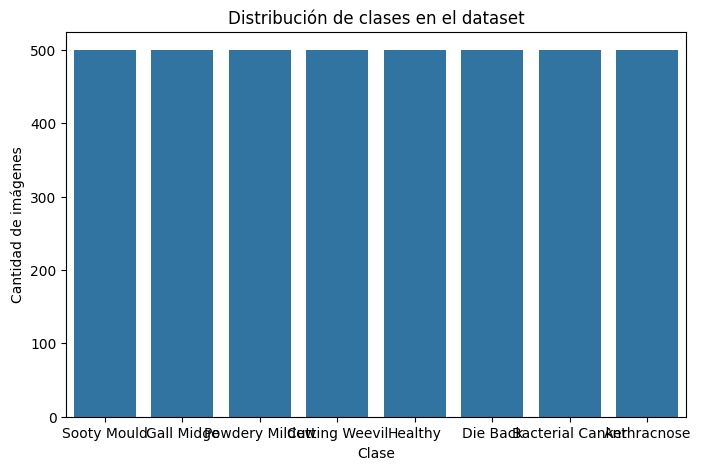

In [ ]:
import seaborn as sns
import pandas as pd

# Crear un DataFrame para análisis exploratorio
df = pd.DataFrame({'Etiqueta': y})

# Gráfico de conteo de clases
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Etiqueta')
plt.title("Distribución de clases en el dataset")
plt.xlabel("Clase")
plt.ylabel("Cantidad de imágenes")
plt.show()


En esta sección del código se realiza un análisis exploratorio de datos (EDA) básico para visualizar la distribución de clases presentes en el conjunto de imágenes cargado. Para ello, se utiliza la biblioteca pandas para crear un DataFrame a partir del vector de etiquetas y, que contiene las categorías asignadas a cada imagen (por ejemplo, diferentes tipos de enfermedades en hojas de mango). Luego, se emplea seaborn, una biblioteca de visualización basada en Matplotlib, para construir un gráfico de barras mediante sns.countplot, que muestra la cantidad de imágenes disponibles para cada clase. Esta visualización permite identificar posibles desequilibrios en el dataset, como clases con más imágenes que otras, lo cual es importante porque un desbalance podría sesgar el rendimiento del modelo de clasificación. El gráfico generado incluye un título descriptivo y etiquetas en los ejes para mejorar la legibilidad y la interpretación de los resultados. En conjunto, esta etapa ofrece una visión general sobre la distribución de las muestras, facilitando decisiones posteriores como la necesidad de aplicar técnicas de balanceo o ajustar las métricas de evaluación.

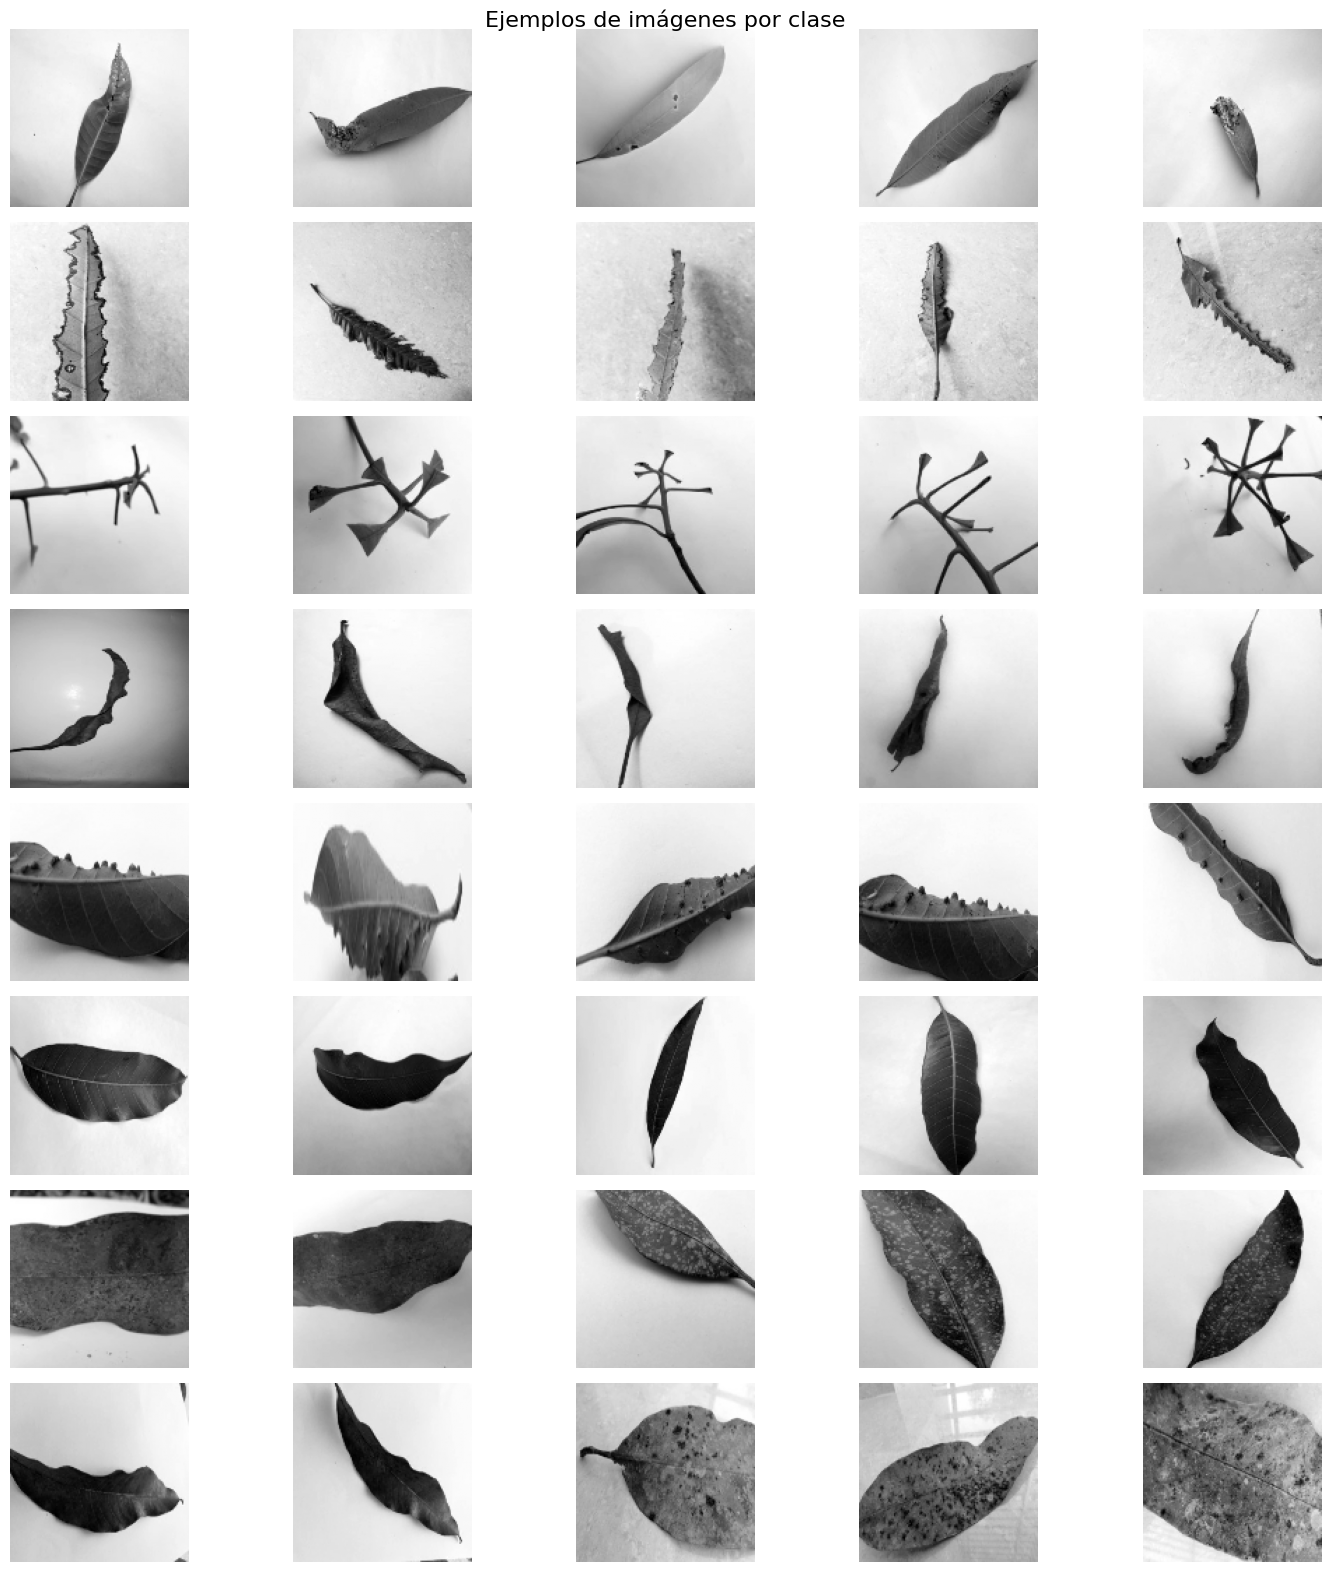

In [ ]:
# Función para graficar muestras por clase
def mostrar_muestras(X, y, clases, muestras_por_clase=5):

    plt.figure(figsize=(15, len(clases) * 2))
    for i, clase in enumerate(clases):
        idxs = np.where(y == clase)[0][:muestras_por_clase]
        for j, idx in enumerate(idxs):
            plt.subplot(len(clases), muestras_por_clase, i * muestras_por_clase + j + 1)
            plt.imshow(X[idx], cmap='gray')
            plt.axis('off')
            if j == 0:
                plt.ylabel(clase, fontsize=12)
    plt.suptitle("Ejemplos de imágenes por clase", fontsize=16)
    plt.tight_layout()
    plt.show()

# Llamada a la función
clases_unicas = np.unique(y)
mostrar_muestras(X, y, clases_unicas)

La función mostrar_muestras(X, y, clases, muestras_por_clase=5) permite visualizar ejemplos representativos del dataset, organizados por clase, lo cual es una práctica esencial en el análisis exploratorio de imágenes. Su objetivo es facilitar la comprensión visual del contenido del conjunto de datos y detectar posibles problemas de calidad, variabilidad intra-clase o patrones relevantes. Esta función recibe como entrada el conjunto de imágenes X, sus etiquetas y, un arreglo con los nombres o identificadores únicos de las clases (clases), y el número de muestras a mostrar por clase. Internamente, para cada clase, se seleccionan los primeros n índices que corresponden a esa etiqueta utilizando np.where, y se genera una figura con subplots organizados en filas por clase y columnas por número de muestras. Cada imagen se muestra con plt.imshow en escala de grises (cmap='gray'), y se desactivan los ejes para una visualización más limpia. Además, la primera imagen de cada fila se etiqueta con el nombre de la clase correspondiente como eje y, proporcionando contexto visual. Finalmente, se aplica un título general a la figura y se ajusta el espaciado para evitar solapamientos. Esta herramienta es útil para verificar visualmente la diversidad y consistencia de las imágenes en cada clase, permitiendo detectar outliers, imágenes mal etiquetadas o clases con características poco definidas.

In [ ]:
formas = [img.shape for img in X]
formas_unicas = set(formas)

print("Formas únicas encontradas en las imágenes:", formas_unicas)


Formas únicas encontradas en las imágenes: {(128, 128)}


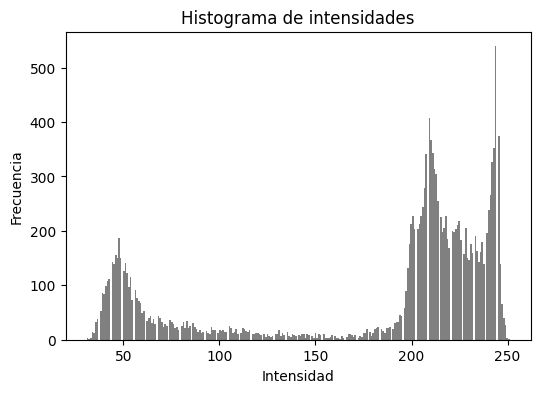

In [ ]:
def mostrar_histograma(imagen):

    plt.figure(figsize=(6, 4))
    plt.hist(imagen.ravel(), bins=256, color='gray')
    plt.title("Histograma de intensidades")
    plt.xlabel("Intensidad")
    plt.ylabel("Frecuencia")
    plt.show()

# Ver histograma de una muestra
mostrar_histograma(X[0])


La función mostrar_histograma(imagen) tiene como propósito visualizar la distribución de niveles de intensidad en una imagen en escala de grises mediante un histograma. Esta herramienta resulta útil durante el análisis exploratorio de datos (EDA), ya que permite evaluar el contraste, la luminosidad y la presencia de posibles artefactos o regiones sobresaturadas. Internamente, la función convierte la imagen de dos dimensiones (matriz 2D) en un vector unidimensional utilizando .ravel(), lo cual permite representar todas las intensidades en un solo eje. Posteriormente, se utiliza plt.hist para generar un histograma con 256 bins, correspondientes a los posibles valores de intensidad en imágenes de 8 bits (0 a 255). La gráfica se presenta en color gris para mantener coherencia visual con la imagen original. Se añaden etiquetas a los ejes y un título descriptivo, lo que facilita la interpretación. Esta visualización permite detectar si una imagen está muy oscura, muy clara, o si tiene buen rango dinámico, lo cual puede influir en la calidad de las características extraídas posteriormente. Finalmente, la función se ejemplifica con una llamada sobre X[0], es decir, la primera imagen del conjunto de datos cargado.

In [ ]:
# Función para extraer vectores HOG
def extraer_hog(imagenes):
    hog_features = []
    for img in imagenes:
        features, _ = hog(img, orientations=9, pixels_per_cell=(8, 8),
                          cells_per_block=(2, 2), block_norm='L2-Hys', visualize=True)
        hog_features.append(features)
    return np.array(hog_features)

X_hog = extraer_hog(X)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2, random_state=42)


In [ ]:
modelo = SVC(kernel='linear')
modelo.fit(X_train, y_train)


SVC(kernel='linear')

In [ ]:
y_pred = modelo.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nReporte de Clasificación:\n", classification_report(y_test, y_pred))


Accuracy: 0.77125
F1-Score: 0.7719525691178961

Reporte de Clasificación:
                   precision    recall  f1-score   support

     Anthracnose       0.64      0.68      0.66        93
Bacterial Canker       0.79      0.92      0.85        91
  Cutting Weevil       0.99      0.97      0.98       101
        Die Back       0.93      0.86      0.89        90
      Gall Midge       0.61      0.72      0.66        86
         Healthy       0.69      0.74      0.71       104
  Powdery Mildew       0.85      0.71      0.78       112
     Sooty Mould       0.73      0.62      0.67       123

        accuracy                           0.77       800
       macro avg       0.78      0.78      0.77       800
    weighted avg       0.78      0.77      0.77       800

